In [1]:
import yfinance as yf
import pandas as pd

In [2]:
df = yf.download('BTC-USD', start='2018-01-01', end='2022-03-30')[['Close']]
df.index = pd.to_datetime(df.index)
df.round(2).head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2017-12-31,14156.4
2018-01-01,13657.2
2018-01-02,14982.1
2018-01-03,15201.0
2018-01-04,15599.2


In [3]:
# polt the data

import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

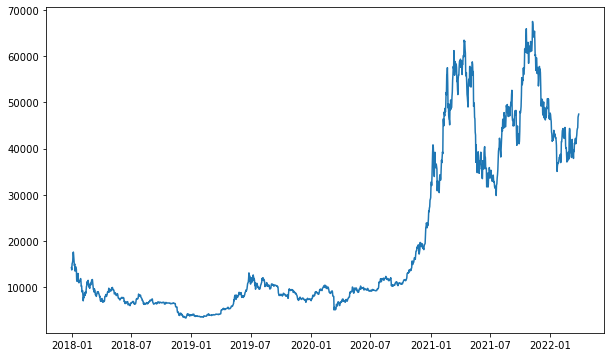

In [4]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Close'])

In [5]:
# check stationarity

from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['Close'])
Pvalue = ADF_result[1]
Pvalue

# P value is higher than 5%, we will not reject the H0 which means data is not stationary

0.8377917566546507

/var/folders/9y/45l79l3x40s95c93b61_6txw0000gn/T/ipykernel_47300/3547812573.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df, model='additive', freq=1)


Text(0.5, 0.98, 'Multiplicative Decompose')

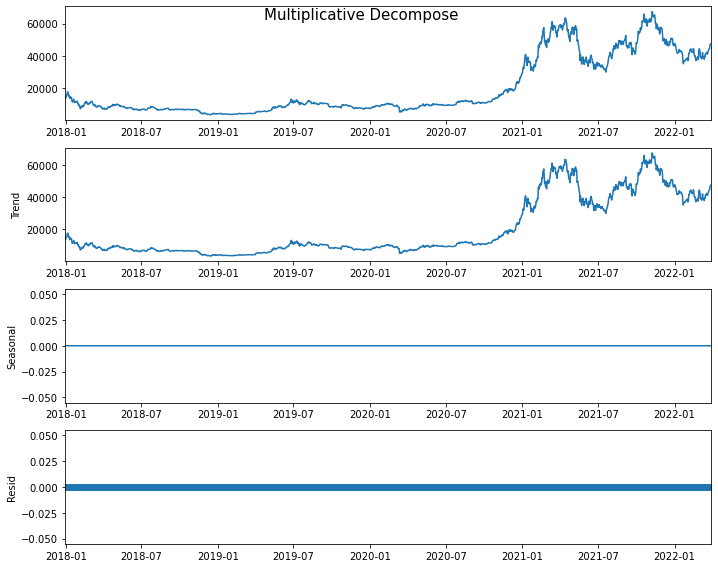

In [6]:
# decompose the series to observe trend, seasonality and residuals

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='additive', freq=1)
plt.rcParams.update({'figure.figsize': (10,8)})
result.plot().suptitle('Multiplicative Decompose', fontsize=15)

# no seasonal components, with some trends observed

In [7]:
# apply aifferencing to have stationarity

df_diff = df.copy()
df_diff['Difference'] = df_diff['Close'].diff()
df_diff.dropna(inplace=True)
df_diff.drop('Close', axis=1, inplace=True)

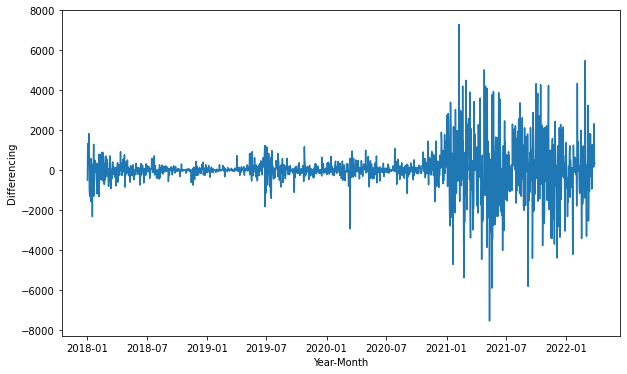

In [8]:
# Plot the new data

plt.figure(figsize=(10,6))
plt.plot(df_diff['Difference'])
plt.xlabel('Year-Month')
plt.ylabel('Differencing')
plt.show()

# more or less stationary after differencing (mean closer to 0)

In [9]:
# reapply ADF

ADF_result2 = adfuller(df_diff['Difference'])
Pvalue2 = ADF_result2[1]
Pvalue2

# Pvalue less than 5%, reject HO, series is now stationary

3.9815487099904493e-11

/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


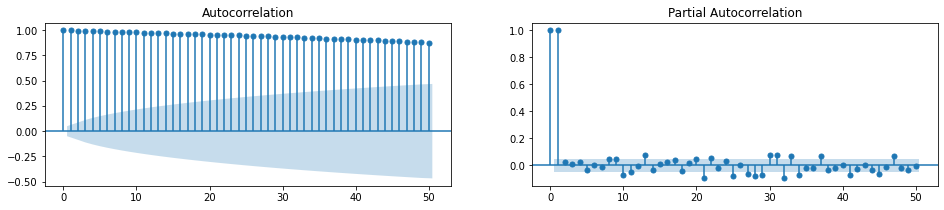

In [10]:
# run ACF(MA) and PACF(AR) checks

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_100 = acf(df.Close, nlags=100)
pacf_100 = pacf(df.Close, nlags=100)

# Draw Plots
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(df.Close.tolist(), lags=50, ax=axes[0])
plot_pacf(df.Close.tolist(), lags=50, ax=axes[1])

plt.show()

In [11]:
# testing various models

# MA(1)
from statsmodels.tsa.arima.model import ARIMA
ma1 = ARIMA(df_diff, order = (0,0,1))
result_ma1 = ma1.fit()
print(result_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:             Difference   No. Observations:                 1549
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -12948.821
Date:                Thu, 31 Mar 2022   AIC                          25903.642
Time:                        12:49:57   BIC                          25919.678
Sample:                    01-01-2018   HQIC                         25909.607
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5038     25.847      0.832      0.405     -29.155      72.162
ma.L1         -0.0288      0.017     -1.710      0.087      -0.062       0.004
sigma2      1.069e+06   1.58e+04     67.605      0.0

/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [12]:
# MA(2)
ma2 = ARIMA(df_diff, order = (0,0,2))
result_ma2 = ma2.fit()
print(result_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:             Difference   No. Observations:                 1549
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -12948.820
Date:                Thu, 31 Mar 2022   AIC                          25905.641
Time:                        12:49:57   BIC                          25927.022
Sample:                    01-01-2018   HQIC                         25913.593
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5038     25.885      0.831      0.406     -29.230      72.237
ma.L1         -0.0288      0.017     -1.714      0.086      -0.062       0.004
ma.L2          0.0005      0.015      0.032      0.9

/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [13]:
# AR(1)
ar1 = ARIMA(df_diff, order = (1,0,0))
result_ar1 = ar1.fit()
print(result_ar1.summary())

/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:             Difference   No. Observations:                 1549
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -12948.821
Date:                Thu, 31 Mar 2022   AIC                          25903.642
Time:                        12:49:57   BIC                          25919.678
Sample:                    01-01-2018   HQIC                         25909.607
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5038     25.830      0.833      0.405     -29.122      72.130
ar.L1         -0.0288      0.017     -1.715      0.086      -0.062       0.004
sigma2      1.068e+06   1.58e+04     67.620      0.0

In [14]:
# ARMA(1,1)
arma11 = ARIMA(df_diff, order = (1,0,1))
result_arma11 = arma11.fit()
print(result_arma11.summary())

/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:             Difference   No. Observations:                 1549
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -12948.821
Date:                Thu, 31 Mar 2022   AIC                          25905.642
Time:                        12:49:57   BIC                          25927.024
Sample:                    01-01-2018   HQIC                         25913.595
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5038     25.913      0.830      0.407     -29.285      72.293
ar.L1         -0.0094      0.538     -0.017      0.986      -1.064       1.046
ma.L1         -0.0194      0.539     -0.036      0.9

In [25]:
# ARIMA(1,1,2)
arima112 = ARIMA(df, order = (1,1,2))
result_arima112 = arima112.fit()
print(result_arima112.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1550
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -12948.367
Date:                Thu, 31 Mar 2022   AIC                          25904.734
Time:                        12:57:25   BIC                          25926.115
Sample:                    12-31-2017   HQIC                         25912.687
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7752      0.207      3.750      0.000       0.370       1.180
ma.L1         -0.8063      0.208     -3.879      0.000      -1.214      -0.399
ma.L2          0.0432      0.015      2.875      0.0

/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/tinghaokao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [16]:
# AIC the smaller the better

In [26]:
models_name = ['MA1', 'MA2', 'AR2', 'ARMA','ARIMA']
results = [result_ma1,result_ma2,result_ar1,result_arma11,result_arima112]
from sklearn.metrics import mean_squared_error
rmse = []
for i in range(0, len(models_name)):
    if i != 4:
        r = mean_squared_error(y_true = df_diff, y_pred = results[i].predict(), squared=False)
        rmse.append(r)
    else:
        r = mean_squared_error(y_true = df, y_pred = results[i].predict(), squared=False)
        rmse.append(r)
aic = []
for i in range(0, len(models_name)):
    if i != 4:
        a = results[i].aic
        aic.append(a)
    else:
         a= results[i].aic
         aic.append(a) 
print(rmse)
print(aic)

[1033.3200346797087, 1033.3199002165832, 1033.320322372683, 1033.3199676181625, 1093.4937713518657]
[25903.642346584576, 25905.640646497315, 25903.642090324436, 25905.642146907783, 25904.733998820346]


In [29]:
results_rmse = list(zip(models_name,rmse))
summary = pd.DataFrame(results_rmse, columns=['models_name','rmse'])
summary['aic'] = aic
summary

,models_name,rmse,aic
0,MA1,1033.320035,25903.642347
1,MA2,1033.319900,25905.640646
2,AR2,1033.320322,25903.642090
3,ARMA,1033.319968,25905.642147
4,ARIMA,1093.493771,25904.733999


In [31]:
forecast = result_arima112.predict(start="2022-04-01", end="2022-08-30")
print(forecast)

# need to add this back to the original time series

2022-04-01    47611.694488
2022-04-02    47643.348604
2022-04-03    47667.885425
2022-04-04    47686.905244
2022-04-05    47701.648536
                  ...     
2022-08-26    47752.475920
2022-08-27    47752.475920
2022-08-28    47752.475920
2022-08-29    47752.475920
2022-08-30    47752.475920
Freq: D, Name: predicted_mean, Length: 152, dtype: float64


/var/folders/9y/45l79l3x40s95c93b61_6txw0000gn/T/ipykernel_47300/59582407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df.index
/var/folders/9y/45l79l3x40s95c93b61_6txw0000gn/T/ipykernel_47300/59582407.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['Close']
/var/folders/9y/45l79l3x40s95c93b61_6txw0000gn/T/ipykernel_47300/59582407.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

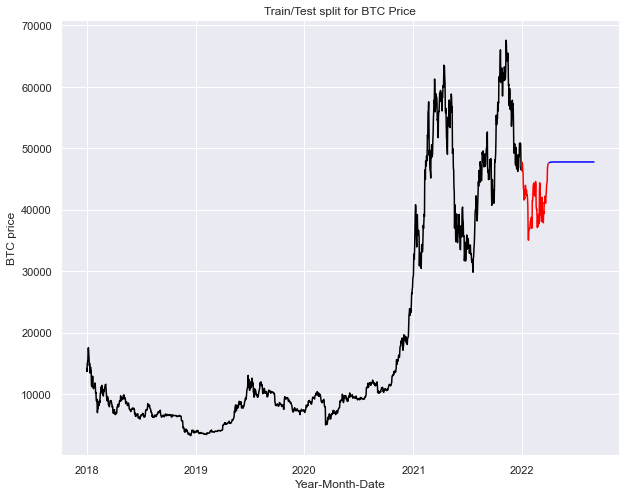

In [33]:
# forecast the future 5 months with model ARIMA112

import seaborn as sns
df['Date'] = df.index
train = df[df['Date'] < pd.to_datetime("2021-12-31",format='%Y-%m-%d')]
train['train'] = train['Close']
del train['Date']
del train['Close']
test = df.loc[df['Date'] >= pd.to_datetime("2021-12-31", format='%Y-%m-%d')]
del test['Date']
test['test'] = test['Close']
del test['Close']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = 'blue')
plt.title("Train/Test split for BTC Price")
plt.ylabel("BTC price")
plt.xlabel("Year-Month-Date")
sns.set()
plt.show()

In [34]:
# I will not buy bitcoin as the price doesn't seem to rise in the following months